##Aluna: Andréa Fonseca

# Regressão Linear com PyTorch

## Objetivo

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se
- o cálculo do gradiente automático do PyTorch, porém
- a função de perda e
- atualização dos parâmetros é feita de forma explícita.
- A rede é criada com uma camada nn.Linear()

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinear_Otimizacao.png)

## Importação dos pacotes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.datasets import load_iris

import torch
from torch import nn, optim
from torch.autograd import Variable

torch.manual_seed(1234)

## Leitura dos dados

In [23]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = data[:,0:1].astype(np.float32)
y_train = data[:,1:2].astype(np.float32)

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float32
y_train.shape: (50, 1) float32
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]


### Normalização dos dados

In [24]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()


In [25]:
print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train[:5]:
 [[1.        ]
 [0.71428573]
 [0.952381  ]
 [0.28571424]
 [0.7619048 ]]
y_train[:5]:
 [[0.80952376]
 [0.71428573]
 [0.90476197]
 [0.4761905 ]
 [0.7619048 ]]


In [26]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train])

In [27]:
x_train_bias

array([[1.        , 1.        ],
       [1.        , 0.71428573],
       [1.        , 0.95238101],
       [1.        , 0.28571424],
       [1.        , 0.76190478],
       [1.        , 0.38095227],
       [1.        , 0.66666675],
       [1.        , 0.        ],
       [1.        , 0.80952376],
       [1.        , 0.14285702],
       [1.        , 0.047619  ],
       [1.        , 0.47619051],
       [1.        , 0.52380949],
       [1.        , 0.57142848],
       [1.        , 0.33333325],
       [1.        , 0.85714275],
       [1.        , 0.33333325],
       [1.        , 0.42857149],
       [1.        , 0.61904752],
       [1.        , 0.33333325],
       [1.        , 0.47619051],
       [1.        , 0.57142848],
       [1.        , 0.66666675],
       [1.        , 0.57142848],
       [1.        , 0.71428573],
       [1.        , 0.80952376],
       [1.        , 0.90476197],
       [1.        , 0.85714275],
       [1.        , 0.52380949],
       [1.        , 0.38095227],
       [1.

In [28]:
print('x_train_bias.shape:',x_train_bias.shape, x_train_bias.dtype)

x_train_bias.shape: (50, 2) float64


In [29]:
x_train_bias = torch.FloatTensor(x_train_bias)
y_train      = torch.FloatTensor(y_train)
print(y_train)

tensor([[0.8095],
        [0.7143],
        [0.9048],
        [0.4762],
        [0.7619],
        [0.7143],
        [0.8095],
        [0.1429],
        [0.7619],
        [0.4286],
        [0.2381],
        [0.5714],
        [0.4762],
        [0.8095],
        [0.2857],
        [0.6667],
        [0.7143],
        [0.5238],
        [0.7143],
        [0.4286],
        [0.8571],
        [0.4762],
        [0.9048],
        [0.8095],
        [0.6190],
        [0.6667],
        [0.8571],
        [0.9524],
        [0.7143],
        [0.2381],
        [0.3810],
        [0.3333],
        [0.4286],
        [1.0000],
        [0.7143],
        [0.7143],
        [0.8095],
        [0.6667],
        [0.5238],
        [0.4762],
        [0.6667],
        [0.7619],
        [0.4762],
        [0.1429],
        [0.5714],
        [0.5714],
        [0.5714],
        [0.6190],
        [0.0000],
        [0.5238]])


## Model

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinearNeuronio.png)

###Inicializando a rede

In [31]:
#Inicialização usando torch.nn.Linear

model = torch.nn.Linear(in_features=2, out_features=1, bias=False)

### Verificando a inicialização dos parâmetros

In [32]:
model.weight.data = torch.zeros(1,2) # inicializando pesos
torch.nn.init.uniform(model.weight.data, -0.1, 0.1) # uniformizando os pesos entre -0,1 e 0,1 de forma randômica
model.weight

<ipython-input-32-029cbc1d61a7>:2: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  torch.nn.init.uniform(model.weight.data, -0.1, 0.1) # uniformizando os pesos entre -0,1 e 0,1 de forma randômica


Parameter containing:
tensor([[0.0567, 0.0126]], requires_grad=True)

requires_grad=True faz o backward propagation de forma automática; indica que a estrutura é do tipo Variable

### Testando o predict da rede

In [33]:
xx = torch.ones((5,2))
xx

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [34]:
model(Variable(xx))

tensor([[0.0694],
        [0.0694],
        [0.0694],
        [0.0694],
        [0.0694]], grad_fn=<MmBackward0>)

## Treinamento

In [35]:
num_epochs = 100
learning_rate = 0.5
for epoch in range(num_epochs):
    inputs = Variable(x_train_bias)
    target = Variable(y_train)

    # forward - predict
    y_pred = model(x_train_bias)

    #loss cálculo da função de perda (J)
    loss = torch.mean((y_pred - y_train)**2)

    # backward propagation - cálculo gradient
    loss.backward()

    # gradiente descendente (ainda cálculo manual)
    model.weight.data = model.weight.data - learning_rate * model.weight.grad.data

    # zeragem parâmetros preparando para o próximo cálculo do gradiente
    model.weight.grad.data.zero_()

    # verbose
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.data))

Epoch[20/100], loss: 0.023083
Epoch[40/100], loss: 0.021446
Epoch[60/100], loss: 0.021210
Epoch[80/100], loss: 0.021175
Epoch[100/100], loss: 0.021170


## Avaliação

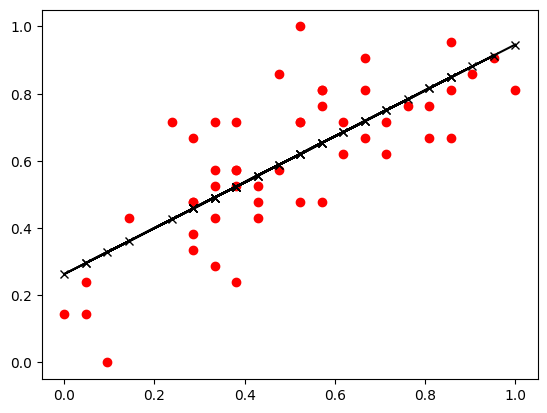

In [36]:
y_pred = model(Variable(x_train_bias))
plt.plot(x_train, y_train.numpy(), 'ro', label='Original data')
plt.plot(x_train, y_pred.data.numpy(), 'kx-', label='Fitting Line')
plt.show()

### Acessando os parâmetros

In [37]:
w_dic = model.state_dict()
w_dic

OrderedDict([('weight', tensor([[0.2632, 0.6829]]))])

### Parâmetros ótimos, solução analítica

In [39]:
x_bias = x_train_bias
y = y_train
x_bias_t = torch.t(x_bias)
w_opt = (torch.inverse(x_bias_t.mm(x_bias)).mm(x_bias_t)).mm(y)
print(torch.t(w_opt))

tensor([[0.2613, 0.6865]])


# Exercícios

- 1) Por que no final da varredura do laço de treinamento, a perda é impressa utilizando
   `loss.data`? Por que precisa do `data`?
   

Porque a estrutura de dados loss é um Variable, que dispõe de data, creator e o gradiente descendente.

- 2) Calcule e imprima o valor da perda (MSE) fazendo o predict da rede com os pesos já
   treinados.

In [46]:
model.state_dict()

OrderedDict([('weight', tensor([[0.2632, 0.6829]]))])

In [44]:
pred = model(x_train_bias)
loss = torch.mean((pred - y_train)**2)

In [45]:
loss

tensor(0.0212, grad_fn=<MeanBackward0>)

- 3) Crie duas listas `w0_list` e `w1_list` para guardar a evolução dos valores dos
   parâmetros durante o laço de treinamento.
   Modifique o exemplo do gráfico tipo **scatter plot** para visualizar a variação
   dos parâmetros do modelo duas dimensões.
   Marque neste gráfico o valor ótimo do parâmetro dado pela solução
   analítica.

## Ploting vectors

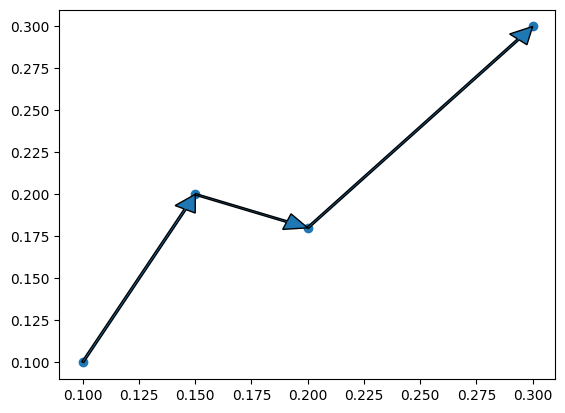

In [ ]:
# Exemplo
w0_list = [0.1, 0.15, 0.2, 0.3]
w1_list = [0.1, 0.2, 0.18, 0.3]
plt.scatter(w0_list,w1_list)
w0_old = None
for (w0,w1) in zip(w0_list,w1_list):
    if w0_old:
        plt.arrow(w0_old, w1_old, w0-w0_old, w1-w1_old,
                  head_length=0.01,head_width=0.01,shape='full',
                  length_includes_head=True)
    w0_old,w1_old = w0,w1

In [49]:
model.weight.data = torch.zeros(1,2)
torch.nn.init.uniform(model.weight.data, -0.1, 0.1)

num_epochs = 100
learning_rate = 0.5

w0 = []
w1 = []

for epoch in range(num_epochs):
    inputs = Variable(x_train_bias)
    target = Variable(y_train)

    # forward - predict
    y_pred = model(x_train_bias)

    #loss cálculo da função de perda (J) com MSE
    loss = torch.mean((y_pred - y_train)**2)

    # backward propagation - cálculo gradient
    loss.backward()

    # gradiente descendente (ainda cálculo manual)
    model.weight.data = model.weight.data - learning_rate * model.weight.grad.data
    w0.append(model.weight.data[0][0])
    w1.append(model.weight.data[0][1])

    # zeragem parâmetros preparando para o próximo cálculo do gradiente
    model.weight.grad.data.zero_()

    # verbose
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.data))

Epoch[20/100], loss: 0.022637
Epoch[40/100], loss: 0.021382
Epoch[60/100], loss: 0.021200
Epoch[80/100], loss: 0.021174
Epoch[100/100], loss: 0.021170


<ipython-input-49-ae717cce3b33>:2: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  torch.nn.init.uniform(model.weight.data, -0.1, 0.1)


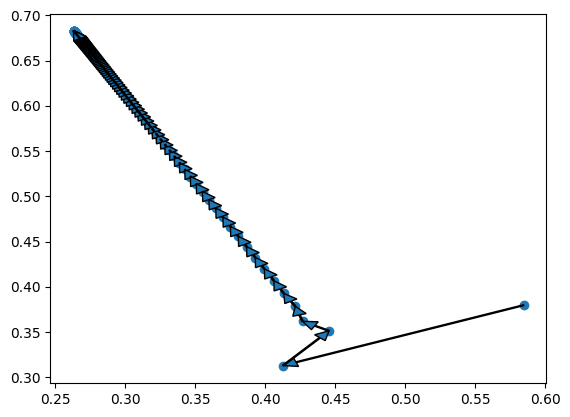

In [51]:
plt.scatter(w0,w1)
w0_old = None
for (w0,w1) in zip(w0,w1):
    if w0_old:
        plt.arrow(w0_old, w1_old, w0-w0_old, w1-w1_old,
                  head_length=0.01,head_width=0.01,shape='full',
                  length_includes_head=True)
    w0_old,w1_old = w0,w1

# Aprendizados

Os pesos começam de forma aleatória no último gráfico e convergem ao valor ideal próximo a (0.28, 0.68)